# NYC Harasment Complaints Data Analysis

This notebook contains snippets that intend to dive into the [NYC Complaints data set](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i) and investigate trends of all different complaint types that were reported during 2016. Further, the notebook focusses on one specfic complaint type.

In [2]:
%matplotlib inline
import pandas
import folium
import datetime 
import zipfile
import matplotlib
import matplotlib.pyplot as plt

# unzipping raw csv file
DATA_FILE_PATH = 'NYPD_Complaint_Data_Historic_2016.csv'
zip_ref = zipfile.ZipFile('NYPD_Complaint_Data_Historic_2016.zip', 'r')
zip_ref.extractall('.')
zip_ref.close()

In [3]:
# parsing data
fullData = pandas.read_csv(DATA_FILE_PATH, sep=',')
print(str(len(fullData)) + ' records in the data set.')

# parsing dates
fullData['CMPLNT_FR_DT'] = pandas.to_datetime(fullData['CMPLNT_FR_DT'], errors='ignore', format='%m/%d/%Y')
fullData['CMPLNT_TO_DT'] = pandas.to_datetime(fullData['CMPLNT_TO_DT'], errors='ignore', format='%m/%d/%Y')

fullData = fullData.sort_values(['CMPLNT_FR_DT'], ascending=True)
fullData['COUNT'] = 1

468290 records in the data set.


### General Complaint Types
First we look at the different description types of complaints in general in 2016:

There are 351 diffreent description types in the data set


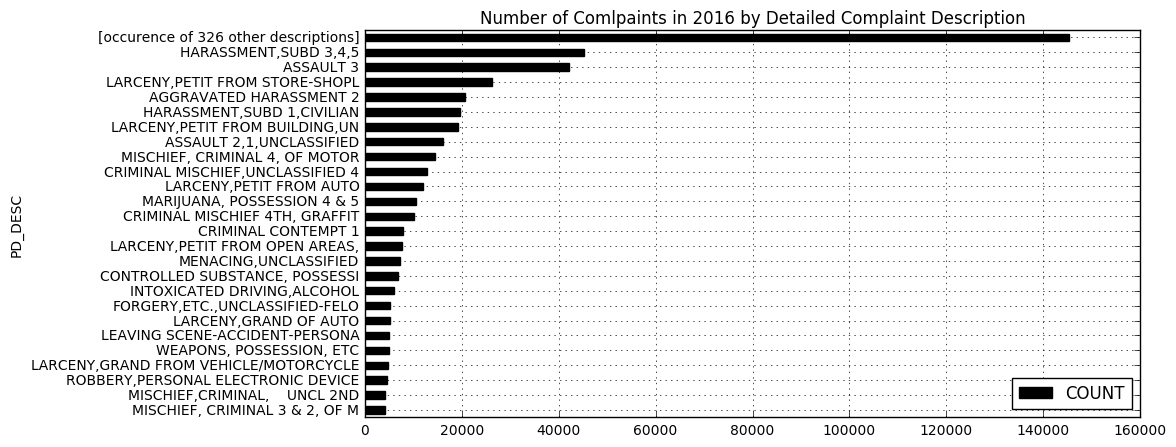

In [54]:
# summing all description types
descriptionTypeCount = len(fullData['PD_DESC'].value_counts())
print('There are ' + str(descriptionTypeCount) + ' diffreent description types in the data set')
descriptionAllTotals = pandas.DataFrame(fullData.groupby(['PD_DESC'])['COUNT'].sum())

#setting boundries for the chart
head = 25
tail = descriptionTypeCount - head

# summing all descriptions that aren't in the top records
descriptionAllTotals = descriptionAllTotals.sort_values(['COUNT'], ascending=False)
descriptionTopTotals = descriptionAllTotals.head(head).reset_index()
otherDescriptionsAmount = descriptionAllTotals.tail(tail)['COUNT'].sum()
otherDescriptionsRow = pandas.DataFrame(
    [['[occurence of '+str(tail)+' other descriptions]', otherDescriptionsAmount]], 
    columns=['PD_DESC', 'COUNT'])
descriptionTotals = descriptionTopTotals.append(otherDescriptionsRow)

# plot the description amounts
plt.rcParams["figure.figsize"] = [10,5]
descriptionTotals = descriptionTotals.sort_values(['COUNT'], ascending=True)
descriptionTotals = descriptionTotals.set_index('PD_DESC')
descriptionTotals.plot.barh(facecolor='k');
plt.title('Number of Comlpaints in 2016 by Detailed Complaint Description')
plt.grid()

Displaying the sum of the top 25 complaint types of 2016 in the chart above, we can see that harasment complaints are the most common complaint, particulary the __HARASMENT,SUB 3,4,5__ type. This is followed by complaints about assault and larency. Other harasment types (__AGGRAVATED HARASSMENT 2__ or __HARASMENT,SUBD 1,CILIVIAN__) seem also very prominent complaint types. We can also see that there is very a long tail of 326 different complaint types. 

Furthermore, it looks like many complaint types are very detailled strings with the main type at the beginning and more detail after a comma. To reduce the complexity of this data set, we will only look at complaint type strings before the comma and sum all records with the same overall complaint type.

After simplifying complaint types, there are now 198 diffreent description types in the data set


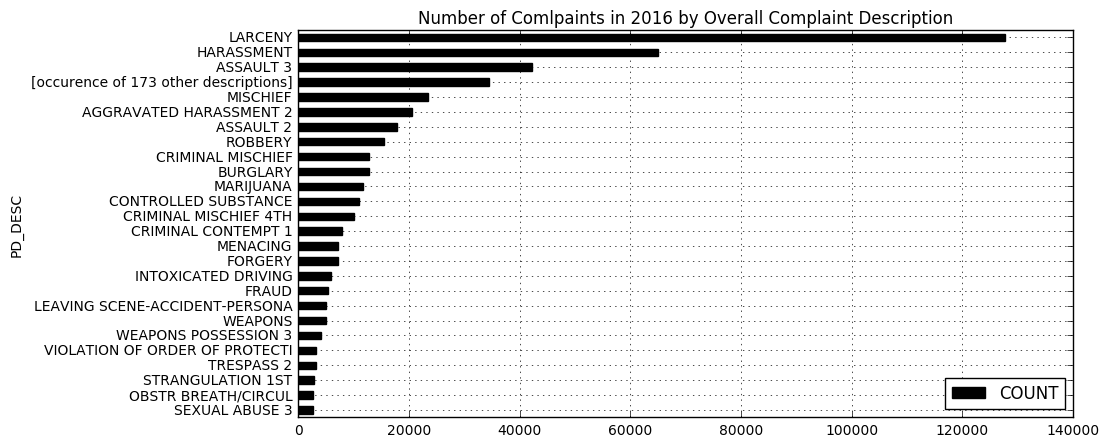

In [55]:
# parse PD_DESC to only look at string before comma
fullData['PD_DESC_full'] = fullData['PD_DESC']
fullData['PD_DESC'] = fullData['PD_DESC'].str.split(',').str[0]
descriptionTypeCount = len(fullData['PD_DESC'].value_counts())
print('After simplifying complaint types, there are now ' + str(descriptionTypeCount) + ' diffreent description types in the data set')
descriptionAllTotals = pandas.DataFrame(fullData.groupby(['PD_DESC'])['COUNT'].sum())

#setting boundries for the chart
head = 25
tail = descriptionTypeCount - head

# combining all description that aren't in the top records
descriptionAllTotals = descriptionAllTotals.sort_values(['COUNT'], ascending=False)
descriptionTopTotals = descriptionAllTotals.head(head).reset_index()
otherDescriptionsAmount = descriptionAllTotals.tail(tail)['COUNT'].sum()
otherDescriptionsRow = pandas.DataFrame([['[occurence of '+str(tail)+' other descriptions]', otherDescriptionsAmount]], columns=['PD_DESC', 'COUNT'])
descriptionTotals = descriptionTopTotals.append(otherDescriptionsRow)

# plot the description amounts
plt.rcParams["figure.figsize"] = [10,5]
descriptionTotals = descriptionTotals.sort_values(['COUNT'], ascending=True)
descriptionTotals = descriptionTotals.set_index('PD_DESC')
descriptionTotals.plot.barh(facecolor='k');
plt.title('Number of Comlpaints in 2016 by Overall Complaint Description')
plt.grid()

We can see now that Larceny is taken the top of the most commen overall complaint, followed by Harassment and Assault 3. We have summarised the 351 different complaint types into 198 overall complaint types.

Now let's look at the data points over time. Below we can see the daily, weekly, monthly and quarterly total amount of complaints, as well as each time aggregation's minimum, maximum, mean and average value.

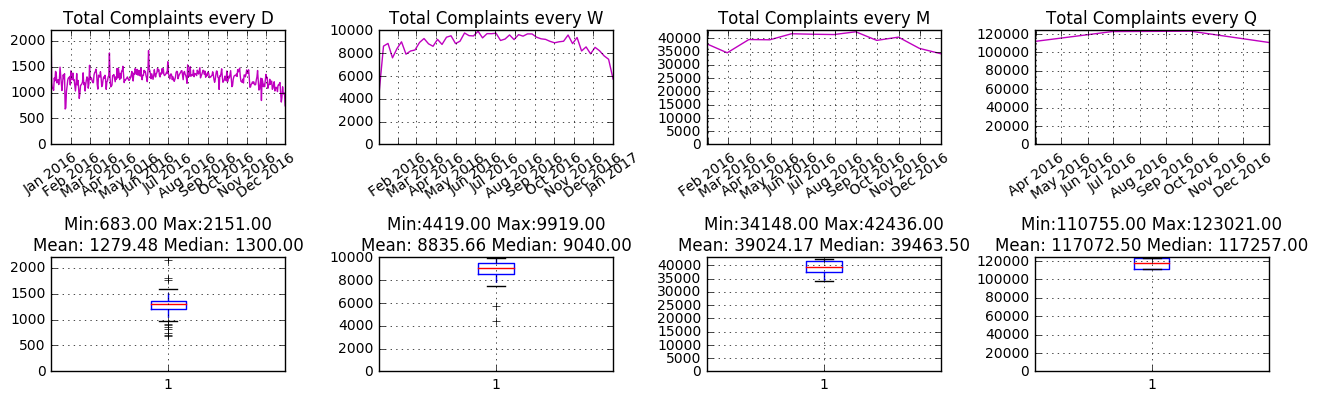

In [37]:
plt.rcParams["figure.figsize"] = [13,13]

# sum over date column
fullDataTimeSeries = pandas.DataFrame(fullData.groupby(['CMPLNT_FR_DT'])['COUNT'].sum()).reset_index()
fullDataTimeSeries = fullDataTimeSeries.sort_values(['CMPLNT_FR_DT'])
fullDataTimeSeries = fullDataTimeSeries.set_index(pandas.DatetimeIndex(fullDataTimeSeries['CMPLNT_FR_DT']))

timeAggs = ['D','W','M','Q']
i = 1

# display for several time aggregation methods
for timeAgg in timeAggs:
    aggregatedDataTimeSeries = fullDataTimeSeries.resample(timeAgg).sum()
    plt.subplot(6, 4, i)
    plt.tight_layout()
    plt.xticks(rotation=35)
    plt.title('Total Complaints every '+timeAgg)
    plt.plot(aggregatedDataTimeSeries, 'm-')
    plt.grid()
    plt.ylim(ymin=0)
    plt.subplot(6, 4, i+4)
    plt.tight_layout()
    plt.boxplot(aggregatedDataTimeSeries['COUNT'])
    plt.ylim(ymin=0)
    plt.title('Min:'+str('%.2f' % aggregatedDataTimeSeries.min().COUNT)+' Max:'+str('%.2f' % aggregatedDataTimeSeries.max().COUNT)+'\nMean: '+str('%.2f' % aggregatedDataTimeSeries.mean().COUNT)+' Median: '+str('%.2f' % aggregatedDataTimeSeries.median().COUNT))
    plt.grid()
    i+=1

It looks like complaints are slightly elevated during the summer months. In the daily pattern we can see a low of complaints during January and two spikes on the beginning of April and June.

Let's have a closer look at the number of daily complaints below:

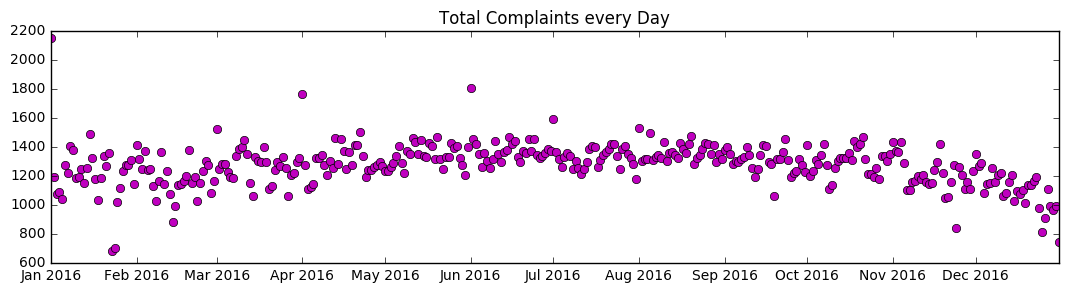

In [38]:
plt.rcParams["figure.figsize"] = [13,3]
plt.title('Total Complaints every Day')
plt.plot(fullDataTimeSeries.resample('D').sum(), 'mo')

The largest amount of reported incidents on one day was on January the 1st, which is most likely related to New Year's Eve. There also appears to be high of reported incidents at the first day of certain, such as March, April, June and July. 
The lowest reported incidents happened between January 23rd and 24th, while the was blizzard in New York. We can also observe a lower number of reported incidents during the end of November, most likely related to Thanksgiving.

Below, we are looking closer at the numbers for each New York Borough.

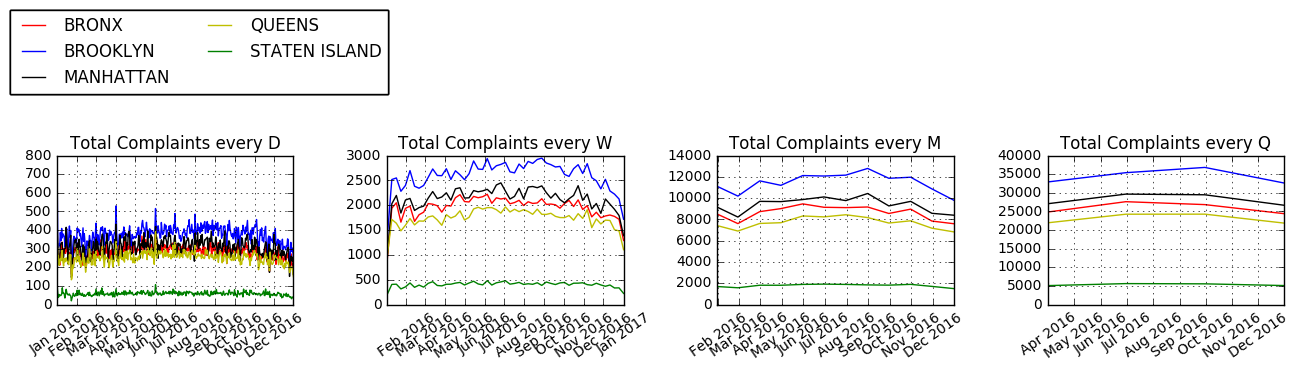

In [39]:
plt.rcParams["figure.figsize"] = [13,13]

# sum over date column by each borough
fullDataTimeSeries = pandas.DataFrame(fullData.groupby(['CMPLNT_FR_DT','BORO_NM'])['COUNT'].sum()).reset_index()
fullDataTimeSeries = fullDataTimeSeries.sort_values(['CMPLNT_FR_DT'])
fullDataTimeSeries = fullDataTimeSeries.set_index(pandas.DatetimeIndex(fullDataTimeSeries['CMPLNT_FR_DT']))
fullDataTimeSeries = fullDataTimeSeries.pivot(columns='BORO_NM')['COUNT']

timeAggs = ['D','W','M','Q']
i = 1

# display for several time aggregation methods
for timeAgg in timeAggs:
    aggregatedDataTimeSeries = fullDataTimeSeries.resample(timeAgg).sum()
    plt.subplot(6, 4, i)
    plt.tight_layout()
    plt.xticks(rotation=35)
    plt.title('Total Complaints every '+timeAgg)
    plt.plot(aggregatedDataTimeSeries['BRONX'], 'r-', label='BRONX')
    plt.plot(aggregatedDataTimeSeries['BROOKLYN'], 'b-', label='BROOKLYN')
    plt.plot(aggregatedDataTimeSeries['MANHATTAN'], 'k-', label='MANHATTAN')
    plt.plot(aggregatedDataTimeSeries['QUEENS'], 'y-', label='QUEENS')
    plt.plot(aggregatedDataTimeSeries['STATEN ISLAND'], 'g-', label='STATEN ISLAND')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, borderaxespad=0., bbox_transform=plt.gcf().transFigure)
    plt.grid()
    plt.ylim(ymin=0)
    i+=1

(0, 800.0)

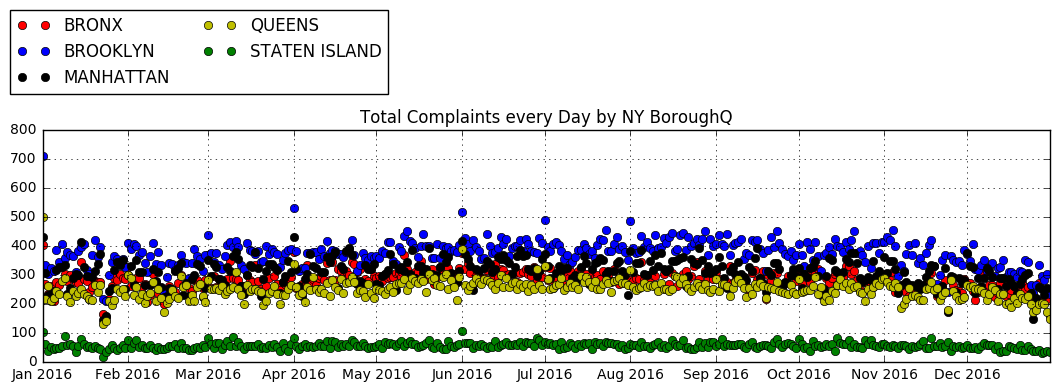

In [51]:
plt.rcParams["figure.figsize"] = [13,3]
aggregatedDataTimeSeries = fullDataTimeSeries.resample('D').sum()
plt.title('Total Complaints every Day by NY Borough'+timeAgg)
plt.plot(aggregatedDataTimeSeries['BRONX'], 'ro', label='BRONX')
plt.plot(aggregatedDataTimeSeries['BROOKLYN'], 'bo', label='BROOKLYN')
plt.plot(aggregatedDataTimeSeries['MANHATTAN'], 'ko', label='MANHATTAN')
plt.plot(aggregatedDataTimeSeries['QUEENS'], 'yo', label='QUEENS')
plt.plot(aggregatedDataTimeSeries['STATEN ISLAND'], 'go', label='STATEN ISLAND')
plt.legend(bbox_to_anchor=(0.1, 1.02, 0., .102), loc=3,
       ncol=2, borderaxespad=0., bbox_transform=plt.gcf().transFigure)
plt.grid()
plt.ylim(ymin=0)

It appears all boroughs follow a similar trend.

In the small multiple charts below, we dig deeper into the monthly number of total complaints for the top 25 complaint types of the 198 simplified complaint strings in the data set. The charts also show by how much percent the complaints changed each month, as well as the minimum, maximum, mean and average of the total monthly amount for each complaint type.

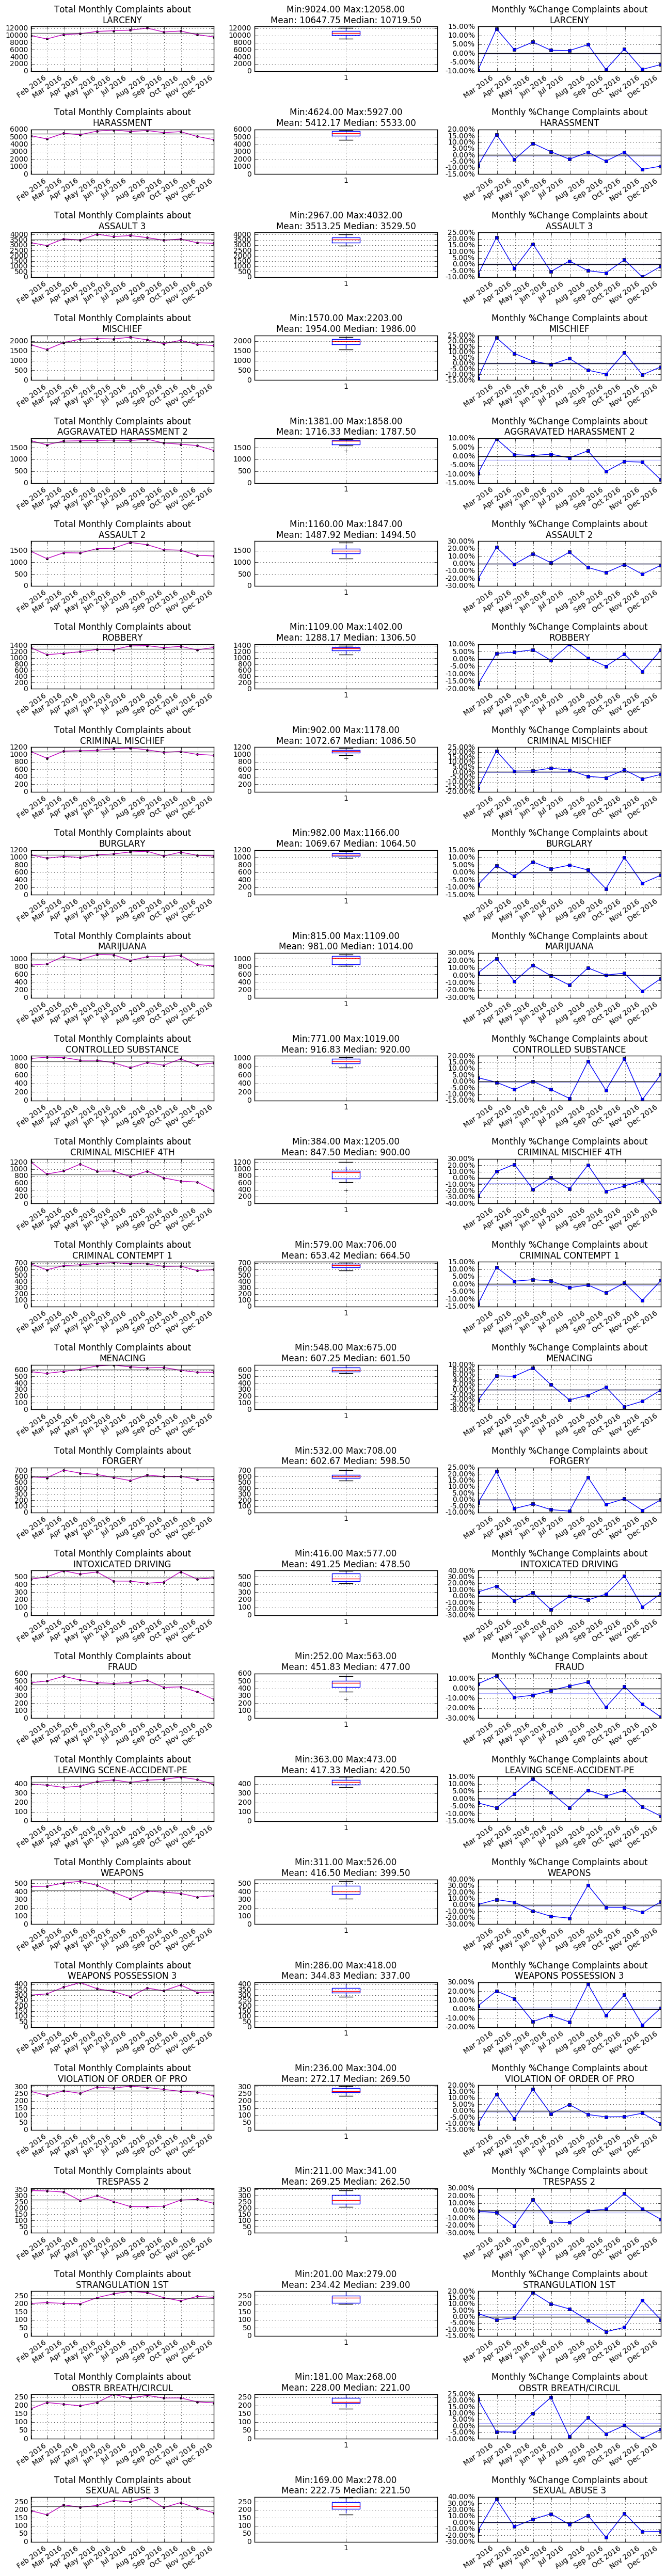

In [65]:
# get top 25 description types
descArr = descriptionAllTotals.reset_index()['PD_DESC'].tolist()
descArr = descArr[:25]

# set chart settings
plt.rcParams["figure.figsize"] = [13,len(descArr)*2]
plt.title('Monthly Total and % Change of Number of Harrasment Complaints per Reported Location')
i = 1

fullDataTimeSeries = pandas.DataFrame(fullData.groupby(['CMPLNT_FR_DT','BORO_NM','PD_DESC'])['COUNT'].sum()).reset_index()
fullDataTimeSeries = fullDataTimeSeries.sort_values(['CMPLNT_FR_DT'])
fullDataTimeSeries = fullDataTimeSeries.set_index(pandas.DatetimeIndex(fullDataTimeSeries['CMPLNT_FR_DT']))

# create chart row for each description type
for desc in descArr:
    tempDF = pandas.DataFrame(fullDataTimeSeries[(fullDataTimeSeries['PD_DESC'] == desc)]) 
    tempDF = tempDF.set_index(pandas.DatetimeIndex(tempDF['CMPLNT_FR_DT']))
    tempDF = tempDF.resample("M").sum()
    plt.subplot(len(descArr), 3, i)
    plt.tight_layout()
    plt.plot(tempDF, 'k.', tempDF, 'm-')
    plt.xticks(rotation=35)
    descTitle = desc[:25]
    plt.title('Total Monthly Complaints about\n'+descTitle)
    plt.ylim(ymin=0)
    plt.grid()
    plt.axhline(tempDF.COUNT.mean(), color='black', alpha=0.6)
    i+=1       
    plt.subplot(len(descArr), 3, i)
    plt.tight_layout()
    plt.boxplot(tempDF['COUNT'])
    plt.ylim(ymin=0)
    plt.title('Min:'+str('%.2f' % tempDF.min().COUNT)+' Max:'+str('%.2f' % tempDF.max().COUNT)+'\nMean: '+str('%.2f' % tempDF.mean().COUNT)+' Median: '+str('%.2f' % tempDF.median().COUNT))
    plt.grid()
    i+=1
    tempDF = tempDF.pct_change();
    ax = plt.subplot(len(descArr), 3, i)
    plt.plot(tempDF, 'bs', tempDF, 'b-', markersize=5)
    plt.xticks(rotation=35)
    plt.tight_layout()
    plt.title('Monthly %Change Complaints about\n'+descTitle)
    plt.grid()
    plt.axhline(0, color='black')
    plt.axhline(tempDF.COUNT.mean(), color='blue', alpha=0.3)
    plt.axhline(0, color='black', alpha=0.2)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
    i+=1

There are some interesting and also concerning trends for some complaint types. Further steps on this sould be to compare these time series with 2015 and the latest 2017 data.

### Digging deeper into a certain complaint type
Below we are looking closer at only a certain complaint type and breaking the data down by their reported location. We will break down the data in the same way as above. At the end of the report, there is also a map displaying the occurrences of each reported incident of the particular complaint type.

In [58]:
PD_DESC_FILTER = 'ASSAULT' # change this string to see the data below displayed for any other complaint type

# filter data set on description filter
pdDescFilteredData = fullData[fullData['PD_DESC'].str.contains(PD_DESC_FILTER)==True].sort_values(['CMPLNT_FR_DT'])
print(str(len(pdDescFilteredData)) + ' records in the 2016 ' + PD_DESC_FILTER + ' data.')

60028 records in the 2016 ASSAULT data.


There are 66 diffreent location types in the data set


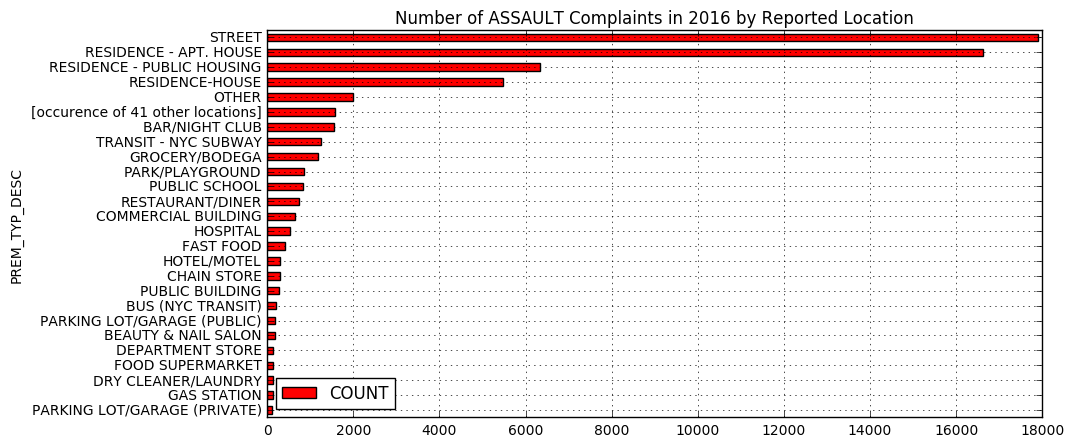

In [59]:
locationTypeCount = len(pdDescFilteredData['PREM_TYP_DESC'].value_counts())
print('There are ' + str(locationTypeCount) + ' diffreent location types in the data set')

pdDescFilteredDataTotals = pandas.DataFrame(pdDescFilteredData.groupby(['PREM_TYP_DESC'])['COUNT'].sum())

#setting boundries for the chart
head = 25
tail = locationTypeCount - head

# combining all location types that aren't in the top records
pdDescFilteredDataTotals = pdDescFilteredDataTotals.sort_values(['COUNT'], ascending=False)
pdDescFilteredDataTopTotals = pdDescFilteredDataTotals.head(25)
otherLocationAmount = pdDescFilteredDataTotals.tail(locationTypeCount-25)['COUNT'].sum()
otherLocationRow = pandas.DataFrame([['[occurence of '+str(tail)+' other locations]', otherLocationAmount]], columns=['PREM_TYP_DESC', 'COUNT']).set_index('PREM_TYP_DESC')
pdDescFilteredDataFilteredTotals = pdDescFilteredDataTopTotals.append(otherLocationRow)

# plot the location amounts
plt.rcParams["figure.figsize"] = [10,5]
pdDescFilteredDataFilteredTotals = pdDescFilteredDataFilteredTotals.sort_values(['COUNT'], ascending=True)
pdDescFilteredDataFilteredTotals.plot.barh(facecolor='r');
plt.title('Number of ' + PD_DESC_FILTER + ' Complaints in 2016 by Reported Location')
plt.grid()

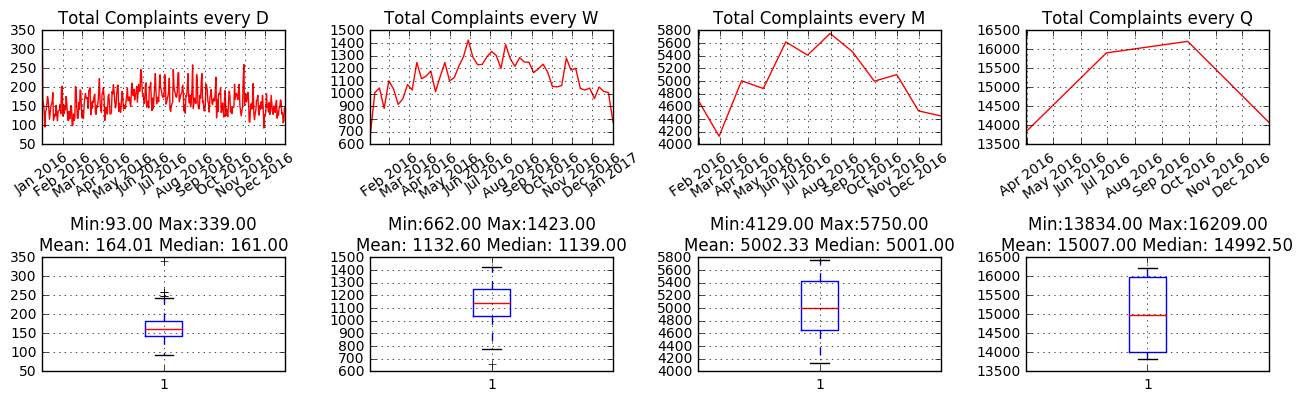

In [60]:
plt.rcParams["figure.figsize"] = [13,13]

# sum over date column
pdDescFilteredDataTimeSeries = pandas.DataFrame(pdDescFilteredData.groupby(['CMPLNT_FR_DT'])['COUNT'].sum()).reset_index()
pdDescFilteredDataTimeSeries = pdDescFilteredDataTimeSeries.sort_values(['CMPLNT_FR_DT'])
pdDescFilteredDataTimeSeries = pdDescFilteredDataTimeSeries.set_index(pandas.DatetimeIndex(pdDescFilteredDataTimeSeries['CMPLNT_FR_DT']))

timeAggs = ['D','W','M','Q']
i = 1

# display for several time aggregation methods
for timeAgg in timeAggs:
    aggregatedpdDescFilteredDataTimeSeries = pdDescFilteredDataTimeSeries.resample(timeAgg).sum()
    plt.subplot(6, 4, i)
    plt.tight_layout()
    plt.xticks(rotation=35)
    plt.title('Total Complaints every '+timeAgg)
    plt.plot(aggregatedpdDescFilteredDataTimeSeries, 'r-')
    plt.grid()
    plt.subplot(6, 4, i+4)
    plt.tight_layout()
    plt.boxplot(aggregatedpdDescFilteredDataTimeSeries['COUNT'])
    plt.title('Min:'+str('%.2f' % aggregatedpdDescFilteredDataTimeSeries.min().COUNT)+' Max:'+str('%.2f' % aggregatedpdDescFilteredDataTimeSeries.max().COUNT)+'\nMean: '+str('%.2f' % aggregatedpdDescFilteredDataTimeSeries.mean().COUNT)+' Median: '+str('%.2f' % aggregatedpdDescFilteredDataTimeSeries.median().COUNT))
    plt.grid()
    i+=1

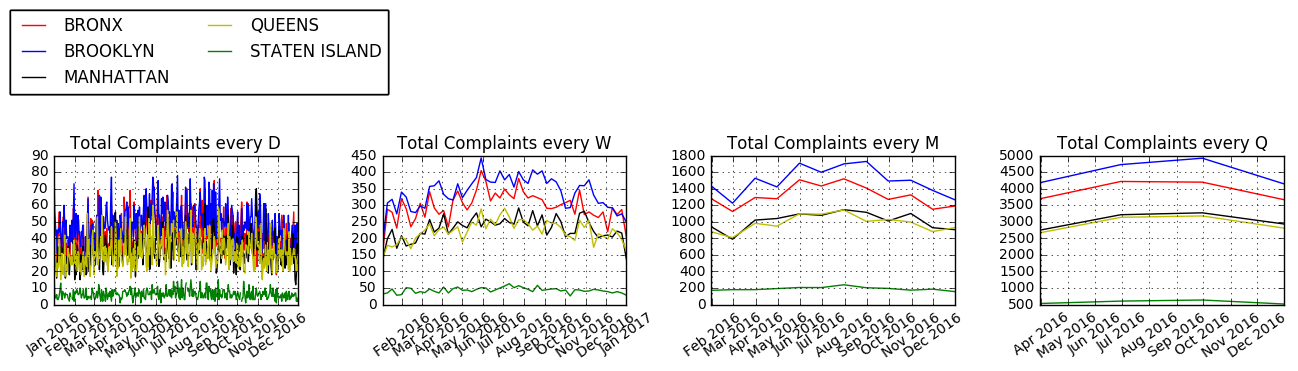

In [61]:
plt.rcParams["figure.figsize"] = [13,13]

# sum over date column by borough
pdDescFilteredDataTimeSeries = pandas.DataFrame(pdDescFilteredData.groupby(['CMPLNT_FR_DT','BORO_NM'])['COUNT'].sum()).reset_index()
pdDescFilteredDataTimeSeries = pdDescFilteredDataTimeSeries.sort_values(['CMPLNT_FR_DT'])
pdDescFilteredDataTimeSeries = pdDescFilteredDataTimeSeries.set_index(pandas.DatetimeIndex(pdDescFilteredDataTimeSeries['CMPLNT_FR_DT']))
pdDescFilteredDataTimeSeries = pdDescFilteredDataTimeSeries.pivot(columns='BORO_NM')['COUNT']

# display for several time aggregation methods
timeAggs = ['D','W','M','Q']
i = 1

for timeAgg in timeAggs:
    aggregatedpdDescFilteredDataTimeSeries = pdDescFilteredDataTimeSeries.resample(timeAgg).sum()
    plt.subplot(6, 4, i)
    plt.tight_layout()
    plt.xticks(rotation=35)
    plt.title('Total Complaints every '+timeAgg)
    plt.plot(aggregatedpdDescFilteredDataTimeSeries['BRONX'], 'r-', label='BRONX')
    plt.plot(aggregatedpdDescFilteredDataTimeSeries['BROOKLYN'], 'b-', label='BROOKLYN')
    plt.plot(aggregatedpdDescFilteredDataTimeSeries['MANHATTAN'], 'k-', label='MANHATTAN')
    plt.plot(aggregatedpdDescFilteredDataTimeSeries['QUEENS'], 'y-', label='QUEENS')
    plt.plot(aggregatedpdDescFilteredDataTimeSeries['STATEN ISLAND'], 'g-', label='STATEN ISLAND')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, borderaxespad=0., bbox_transform=plt.gcf().transFigure)
    plt.grid()
    i+=1

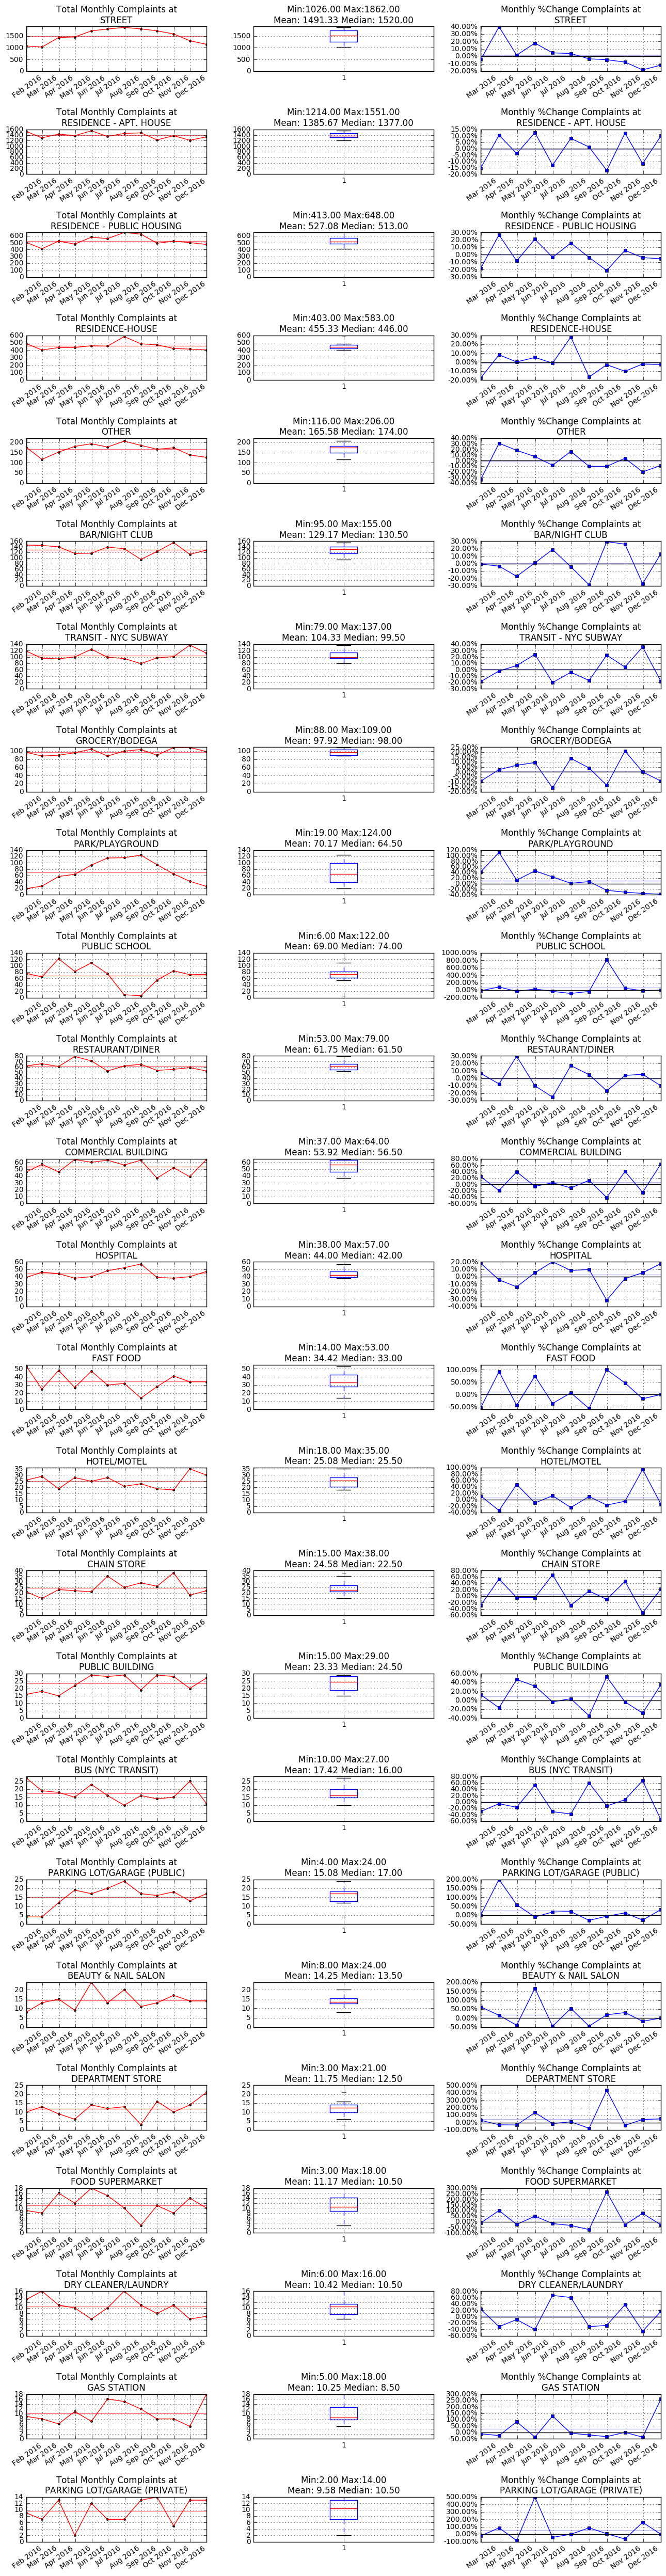

In [64]:
# get top 25 location description
pdDescFilteredDataTimeSeries = pandas.DataFrame(pdDescFilteredData.groupby(['CMPLNT_FR_DT','PREM_TYP_DESC'])['COUNT'].sum()).reset_index()
descArr = pdDescFilteredDataTotals.reset_index()['PREM_TYP_DESC'].tolist()
descArr = descArr[:25]

# set chart settings
plt.rcParams["figure.figsize"] = [13,len(descArr)*2]
plt.title('Monthly Total and % Change of Number of Harrasment Complaints per Reported Location')
i = 1

# create chart row for each description type
for desc in descArr:
    tempDF = pandas.DataFrame(pdDescFilteredDataTimeSeries[(pdDescFilteredDataTimeSeries['PREM_TYP_DESC'] == desc)]) 
    tempDF = tempDF.set_index(pandas.DatetimeIndex(tempDF['CMPLNT_FR_DT']))
    tempDF = tempDF.resample("M").sum()
    plt.subplot(len(descArr), 3, i)
    plt.tight_layout()
    plt.plot(tempDF, 'k.', tempDF, 'r-')
    plt.xticks(rotation=35)
    plt.title('Total Monthly Complaints at\n'+desc)
    plt.ylim(ymin=0)
    plt.grid()
    plt.axhline(tempDF.COUNT.mean(), color='red', alpha=0.6)
    i+=1       
    plt.subplot(len(descArr), 3, i)
    plt.tight_layout()
    plt.boxplot(tempDF['COUNT'])
    plt.title('Min:'+str('%.2f' % tempDF.min().COUNT)+' Max:'+str('%.2f' % tempDF.max().COUNT)+'\nMean: '+str('%.2f' % tempDF.mean().COUNT)+' Median: '+str('%.2f' % tempDF.median().COUNT))
    plt.grid()
    plt.ylim(ymin=0)
    i+=1
    tempDF = tempDF.pct_change();
    ax = plt.subplot(len(descArr), 3, i)
    plt.plot(tempDF, 'bs', tempDF, 'b-', markersize=5)
    plt.xticks(rotation=35)
    plt.tight_layout()
    plt.title('Monthly %Change Complaints at\n'+desc)
    plt.grid()
    plt.axhline(0, color='black')
    plt.axhline(tempDF.COUNT.mean(), color='blue', alpha=0.3)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
    i+=1

In [68]:
print(str('Locations of reported occurrences of ' + PD_DESC_FILTER + ' incidents:'))

pdDescLocationFilteredData = pandas.DataFrame(pdDescFilteredData.groupby(['Latitude','Longitude'])['COUNT'].sum())
pdDescLocationFilteredData = pdDescLocationFilteredData.reset_index()
pdDescLocationFilteredData = pdDescLocationFilteredData.round(2)
pdDescLocationFilteredData = pandas.DataFrame(pdDescLocationFilteredData.groupby(['Latitude','Longitude'])['COUNT'].sum())
pdDescLocationFilteredData = pdDescLocationFilteredData.reset_index()

map_2 = folium.Map(location=[40.729771, -73.997263], tiles='Stamen Toner', zoom_start=11)
lat_list = pdDescLocationFilteredData['Latitude'].tolist()
lon_list = pdDescLocationFilteredData['Longitude'].tolist()
con_list = pdDescLocationFilteredData['COUNT'].tolist()

for i in range(0, len(lat_list)):
    folium.CircleMarker(
        location=[lat_list[i],lon_list[i]], 
        radius=con_list[i], 
        color='#8B0000', 
        fill_color='#8B0000'
    ).add_to(map_2)       

map_2

Locations of reported occurrences of ASSAULT incidents:
